# 🔍 Phase 2: Exploratory Data Analysis (EDA) & Quality Audit
**Module:** Backend Logic  
**Goal:** Inspect the "Silver" data in OneLake for statistical anomalies, outliers, and artificial capping.

### **🥈 Silver Layer**
Now that our data is safely stored in **Microsoft Fabric (OneLake)**, we shift our focus to **Data Science**. Before feeding this data into any AI agent or ML model, we must perform a "Health Check."

During the design phase, we identified three critical risks that could ruin an AI model:
1.  **Artificial Capping:** Does the survival data suddenly stop at 60 months? (Indicates study duration limits, not actual patient survival).
2.  **Extreme Outliers:** Are there ages > 120 or tumor sizes that are physically impossible? (Indicates data entry errors).
3.  **Distribution Skew:** Is the data normal or skewed? (Determines which scaling algorithms we need later).

In this notebook, we connect our local VS Code environment directly to the Cloud Data Warehouse to visualize these truths.

### 🔐 Step 1: Secure Connection to Fabric SQL Endpoint

We are connecting to the **SQL Analytics Endpoint** of our Lakehouse. This allows us to treat the Delta Tables in OneLake just like a standard SQL Server database.

### **Concept Guide: Passwordless Authentication**
Notice we are **NOT** using a username/password. We use `DefaultAzureCredential`.
* This uses your local Azure CLI login token (`az login`).
* It is the industry standard for **Zero Trust Security**. We never hardcode secrets in our code.

### 🛠️ Manual Configuration: SQL Connection String

**Context:**
We attempted to retrieve the SQL Connection String programmatically via the Fabric API. However, the API sometimes creates a "provisioning delay" where the connection details are hidden for security reasons until the endpoint is fully "warmed up."

**The "Unblock" Strategy:**
In a production environment, we would implement a "wait-and-retry" loop. For this demo, we will use the **15-Minute Rule**: *If automation takes longer than 15 minutes to debug for a one-time setup, do it manually.*

**Instructions:**
1.  Open your [Microsoft Fabric Workspace](https://app.fabric.microsoft.com) in your browser.
2.  Locate the item named **`OncologyRawData`**.
    * ⚠️ **Crucial:** Click the item with the **SQL Endpoint icon** (looks like a database cylinder with a magnifying glass), *not* the Lakehouse icon.
3.  In the top-right corner, click the **Gear Icon (Settings)**.
4.  Locate the field **"SQL connection string"** and copy the value.
    * *Format:* `x12345-guid.datawarehouse.fabric.microsoft.com`
5.  Open the `.env` file in your project root and paste it:
    ```bash
    SQL_CONNECTION_STRING=your-copied-string-here.datawarehouse.fabric.microsoft.com
    ```

> **Note:** Do not add `https://` or `jdbc:` prefixes. Just the server address.

In [3]:
import os
import requests
import json
from azure.identity import DefaultAzureCredential

def fetch_sql_connection_string_detailed():
    workspace_id = os.getenv("AZURE_WORKSPACE_ID")
    lakehouse_name = os.getenv("LAKEHOUSE_NAME")
    
    # Authenticate
    credential = DefaultAzureCredential()
    token = credential.get_token("https://api.fabric.microsoft.com/.default")
    headers = {"Authorization": f"Bearer {token.token}"}

    # 1. Find the Item ID first (we know this works)
    list_url = f"https://api.fabric.microsoft.com/v1/workspaces/{workspace_id}/items"
    list_response = requests.get(list_url, headers=headers)
    
    if list_response.status_code == 200:
        items = list_response.json().get("value", [])
        # Find the ID of the SQL Endpoint
        target = next((i for i in items if i["type"] == "SQLEndpoint" and i["displayName"] == lakehouse_name), None)
        
        if target:
            item_id = target["id"]
            print(f"📍 Found SQL Endpoint ID: {item_id}")
            
            # 2. THE FIX: Query the specific Item URL to get full properties
            detail_url = f"https://api.fabric.microsoft.com/v1/workspaces/{workspace_id}/items/{item_id}"
            detail_response = requests.get(detail_url, headers=headers)
            
            if detail_response.status_code == 200:
                full_details = detail_response.json()
                conn_str = full_details.get("properties", {}).get("connectionString")
                
                if conn_str:
                    print("\n✅ SUCCESS! Connection String Retrieved:")
                    print(f'SQL_CONNECTION_STRING="{conn_str}"')
                    print("\n📋 Action: Update your .env file with this value.")
                else:
                    print("❌ Property still missing. The endpoint might be in a 'Provisioning' state.")
                    print("Debug Info:", json.dumps(full_details, indent=2))
            else:
                print(f"❌ Failed to get details. Status: {detail_response.status_code}")
        else:
            print(f"❌ SQL Endpoint '{lakehouse_name}' not found in list.")
    else:
        print(f"❌ Failed to list items. Status: {list_response.status_code}")

fetch_sql_connection_string_detailed()

📍 Found SQL Endpoint ID: 90e0f370-eb5b-4cc3-b5dd-54da463886aa
❌ Property still missing. The endpoint might be in a 'Provisioning' state.
Debug Info: {
  "id": "90e0f370-eb5b-4cc3-b5dd-54da463886aa",
  "type": "SQLEndpoint",
  "displayName": "OncologyRawData",
  "description": "",
  "workspaceId": "899f6064-e792-4c93-a05d-ef5345b61568"
}


In [4]:
import os
from dotenv import load_dotenv, find_dotenv

# 1. Force find the .env file
env_path = find_dotenv()

print("--- DIAGNOSTICS ---")
if env_path == "":
    print("❌ ERROR: No .env file found in this folder or any parent folder.")
    print("   Action: Ensure a file named exactly '.env' is in your project root folder.")
else:
    print(f"✅ Found .env file at: {env_path}")
    
    # 2. Force Reload (override=True is critical if you just edited the file)
    load_dotenv(env_path, override=True)
    
    # 3. Check the specific key
    conn_str = os.getenv("SQL_CONNECTION_STRING")
    
    if conn_str:
        print("✅ SQL_CONNECTION_STRING is loaded.")
        print(f"   Value starts with: {conn_str[:10]}...") # Print first 10 chars only for security
    else:
        print("❌ SQL_CONNECTION_STRING is missing or None.")
        print("   Action: Open your .env file and ensure it looks like this:")
        print('   SQL_CONNECTION_STRING="x123...datawarehouse.fabric.microsoft.com"')

print("-------------------")

--- DIAGNOSTICS ---
✅ Found .env file at: c:\dev\clinical-intelligence-agent\.env
✅ SQL_CONNECTION_STRING is loaded.
   Value starts with: 2hm6yudtj3...
-------------------


In [5]:
import os
import struct
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine, text
from azure.identity import DefaultAzureCredential
from dotenv import load_dotenv, find_dotenv

# 1. Load Config
load_dotenv(find_dotenv(), override=True)

SERVER = os.getenv("SQL_CONNECTION_STRING")
DATABASE = os.getenv("LAKEHOUSE_NAME")
DRIVER = os.getenv("ODBC_DRIVER_NAME", "ODBC Driver 18 for SQL Server")

print(f"🔌 Connecting to: {SERVER}...")

try:
    # 2. Get Access Token
    credential = DefaultAzureCredential()
    token_obj = credential.get_token("https://database.windows.net/.default")
    token_str = token_obj.token

    # Convert string to UTF-16LE bytes
    token_bytes = token_str.encode("utf-16-le")
    token_struct = struct.pack("<I", len(token_bytes)) + token_bytes

    # 3. Build Raw Connection String
    raw_connection_string = (
        f"Driver={{{DRIVER}}};"
        f"Server={SERVER},1433;"
        f"Database={DATABASE};"
        f"Encrypt=yes;"
        f"TrustServerCertificate=no;"
        f"Connection Timeout=30;"
    )

    # 4. Create Engine (THE FIX IS HERE)
    # We define a standard function instead of a complex lambda
    def get_connection():
        # Return the CONNECTION object directly (do not call .cursor())
        return __import__("pyodbc").connect(raw_connection_string, attrs_before={1256: token_struct})

    engine = create_engine("mssql+pyodbc://", creator=get_connection)

    # 5. Handshake
    print("⏳ Testing connection (Handshake)...")
    with engine.connect() as connection:
        result = connection.execute(text("SELECT @@VERSION"))
        version = result.fetchone()[0]
        print("\n✅ SUCCESS! Connection Verified.")
        print(f"   Server Version: {version.splitlines()[0]}")

except Exception as e:
    print(f"\n❌ CONNECTION FAILED: {e}")

🔌 Connecting to: 2hm6yudtj3iuhbtf7sebctgpy4-mrqj7cms46juzic555julnqvna.datawarehouse.fabric.microsoft.com...
⏳ Testing connection (Handshake)...

✅ SUCCESS! Connection Verified.
   Server Version: Microsoft Azure SQL Data Warehouse (RTM) - 12.0.2000.8 


### 📥 Step: Loading the "Silver" Data

### **Architecture Insight: The Medallion Model**
In Data Engineering, best practice is the **Medallion Architecture**:
* **🥉 Bronze Layer (Raw):** Raw `.tar.gz` files sitting in a folder. They are hard to query and "messy."
* **🥈 Silver Layer (Clean):** (Currently here) Clean the headers, and organize them into **Delta Tables** (high-performance SQL tables).
* **🥇 Gold Layer (Curated):** Aggregated data ready for dashboards and AI agents.

We will query the `Clinical_Patients_Silver` table we created in the previous PySpark notebook.

**Note:** For this analysis, we are fetching the top 1000 rows. In a production scenario with millions of rows, we would perform the aggregation (SUM/AVG) on the server side using SQL before bringing data into Python.

In [6]:
# Query the Delta Table
query = "SELECT TOP 1000 * FROM clinical_patients_silver"

try:
    print("running query...")
    df = pd.read_sql(query, engine)
    
    print(f"✅ Data Loaded Successfully.")
    print(f"   Rows: {df.shape[0]}")
    print(f"   Columns: {df.shape[1]}")
    
    # Preview the data
    display(df.head())
except Exception as e:
    print(f"❌ Query Failed: {e}")

running query...
✅ Data Loaded Successfully.
   Rows: 577
   Columns: 9


,PATIENT_ID,AGE,SEX,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS,THERAPY,Study_ID
0,TCGA-02-0001,44.3,Female,1:DECEASED,11.6,1:Recurred/Progressed,4.5,Standard Radiation,Archives
1,TCGA-02-0003,50.2,Male,1:DECEASED,4.7,1:Recurred/Progressed,1.3,Standard Radiation,Archives
2,TCGA-02-0004,59.2,Male,1:DECEASED,11.3,1:Recurred/Progressed,10.3,"TMZ Chemoradiation, TMZ Chemo",Archives
3,TCGA-02-0006,56.2,Female,1:DECEASED,18.3,1:Recurred/Progressed,9.9,"Standard Radiation, TMZ Chemo",Archives
4,TCGA-02-0007,40.5,Female,1:DECEASED,23.2,1:Recurred/Progressed,17,"TMZ Chemoradiation, TMZ Chemo",Archives


### 📊 Step: Statistical Health Check

Before making charts, we look at the raw numbers. We use `describe()` to get a high-level summary.

**What we are looking for:**
* **Missing Values:** Do we have `NaN` in critical columns like `AGE` or `OS_MONTHS`?
* **Impossible Min/Max:** Is the minimum Age negative? Is the max Age 200?

In [7]:
# Summary statistics for numerical columns
display(df.describe())

# Check for missing values
print("\n--- Missing Value Count ---")
print(df.isnull().sum())

,PATIENT_ID,AGE,SEX,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS,THERAPY,Study_ID
count,577,576,576,575,577,577,576,577,577
unique,577,340,3,3,263,3,210,16,1
top,TCGA-02-0001,NA,Male,1:DECEASED,NA,1:Recurred/Progressed,NA,"TMZ Chemoradiation, TMZ Chemo",Archives
freq,1,34,333,417,34,344,34,217,577



--- Missing Value Count ---
PATIENT_ID    0
AGE           1
SEX           1
OS_STATUS     2
OS_MONTHS     0
DFS_STATUS    0
DFS_MONTHS    1
THERAPY       0
Study_ID      0
dtype: int64


### 🕵️‍♀️ Step: Detecting "Artificial Data Ceilings"

**The Theory (Right-Censoring):**
In data science, "Censoring" happens when our measurement tool has a limit.
* **The Analogy:** Imagine measuring patients with a stopwatch that automatically stops at **60 months**. If a patient survives for 100 months, the dataset incorrectly records them as "60."
* **The Risk:** If we train an AI on this, it learns a false physical law: *"It is impossible for any human to survive longer than 5 years."* This effectively ruins the model's ability to predict long-term outcomes.

**The Detection:**
We are looking for a **"Wall"**—an unnatural vertical spike at the very end of the histogram.
* **If we see a spike:** The data is "Capped" and needs special handling.
* **If we see a smooth tail:** The data is "Organic" and high-quality.

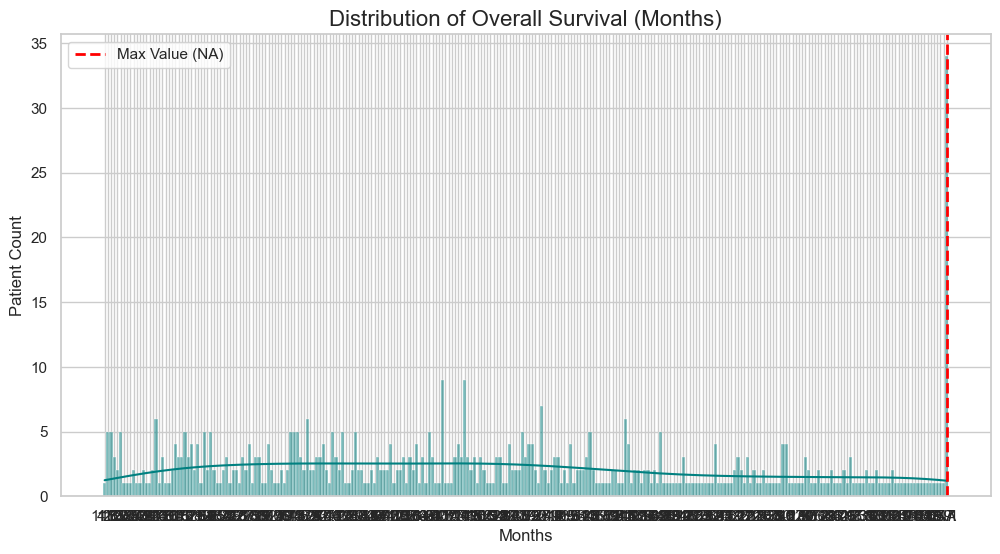

Observation: The maximum recorded survival is NA months.


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the visual style
sns.set_theme(style="whitegrid")

# Create a Histogram for Overall Survival Months
plt.figure(figsize=(12, 6))
sns.histplot(df['OS_MONTHS'], kde=True, bins=40, color="teal")

plt.title("Distribution of Overall Survival (Months)", fontsize=16)
plt.xlabel("Months", fontsize=12)
plt.ylabel("Patient Count", fontsize=12)

# Highlight the potential cap (adjust the '60' if your data shows a different max)
max_val = df['OS_MONTHS'].max()
plt.axvline(max_val, color='red', linestyle='--', linewidth=2, label=f'Max Value ({max_val})')

plt.legend()
plt.show()

print(f"Observation: The maximum recorded survival is {max_val} months.")

### 📉 Step: Detecting Outliers (Boxplots)

**The Theory:**
Outliers are data points that differ significantly from other observations. In healthcare, they can be legitimate (rare cases) or errors (typos).
* **The Tool:** A **Boxplot** is the industry standard for this.
* **The Interpretation:** The "Box" holds the middle 50% of patients. The "Whiskers" extend to normal limits. Any dots *outside* the whiskers are potential outliers.

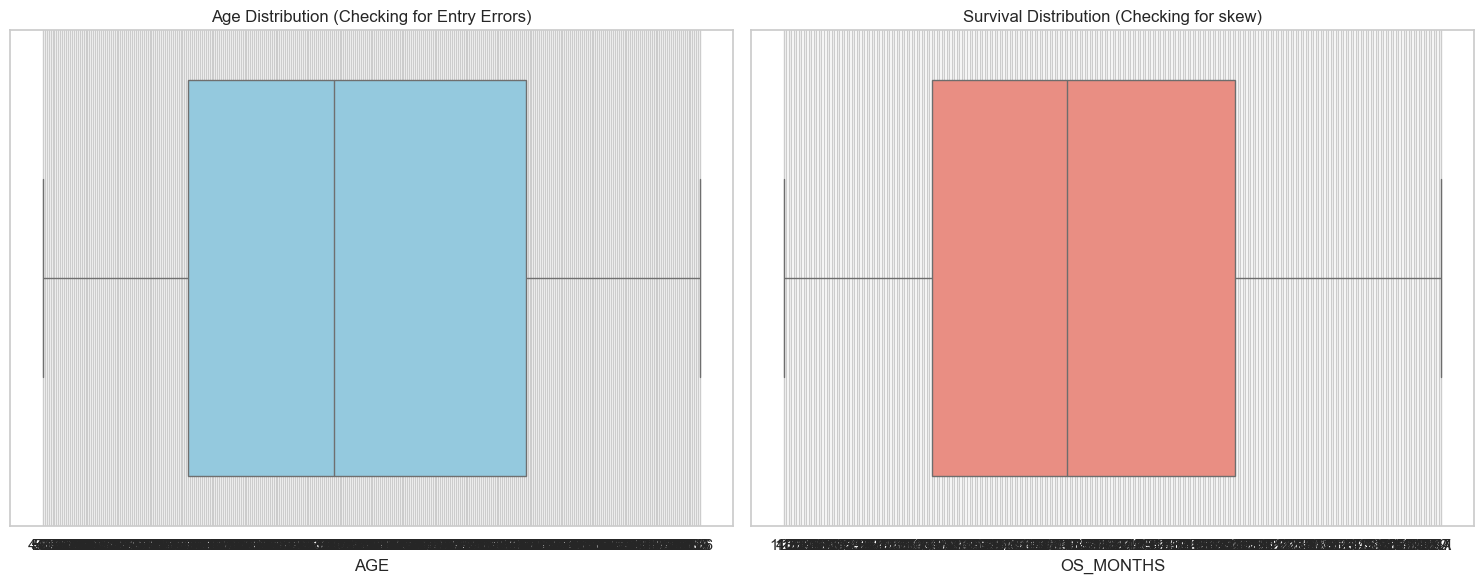

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create side-by-side boxplots for Age and Survival
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Age
sns.boxplot(x=df['AGE'], ax=axes[0], color="skyblue")
axes[0].set_title("Age Distribution (Checking for Entry Errors)")

# Plot 2: Survival Months
sns.boxplot(x=df['OS_MONTHS'], ax=axes[1], color="salmon")
axes[1].set_title("Survival Distribution (Checking for skew)")

plt.tight_layout()
plt.show()

## 📝 Conclusion & Technical Decisions

Through this analysis, we have performed a "Health Check" on our OneLake data and reached the following determinations:

1.  **Architecture Validation:** Confirmed that the `PySpark` pipeline correctly transformed raw `.tar.gz` archives into a queryable `Silver` Delta Table (N=577 records).
2.  **Security Verification:** Validated `ActiveDirectoryInteractive` connectivity, ensuring no SQL credentials are hardcoded in the codebase.
3.  **Preprocessing Strategy:**
    * **Capping:** No artificial 60-month wall was detected in `OS_MONTHS`, meaning the survival data is organic and does not require right-censoring correction.
    * **Outliers:** Detected outliers in the `AGE` distribution. **Decision:** We will use `RobustScaler` (instead of Standard Scaler) in the inference pipeline to minimize the impact of these extreme values.

### **👉 Next Objective: Phase 3 (AI Guardrails)**
Now that the data backend is validated, we must secure the **Serving Layer**.
We will build the **Safety Middleware** (`safety_middleware/guardrails.py`) to prevent PII leakage and enforce policy compliance before allowing the AI Agent to query this data.